In [3]:
!pip install catboost
!pip install shap
from catboost import Pool, CatBoostRegressor, cv

     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 564 kB 26.4 MB/s 


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

In [5]:
!gdown --id 1sDqcZOBEA9s9ulVh5fj9_Ew1M4EMqn8A

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1sDqcZOBEA9s9ulVh5fj9_Ew1M4EMqn8A
To: /content/matrix_cleaned_std.csv
100% 751k/751k [00:00<00:00, 20.3MB/s]


In [8]:
data_all = pd.read_csv('/content/matrix_cleaned_std.csv')
data_all

,Theta,Alpha,Beta,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,Beta/Alpha,Beta/(Alpha + Theta),Beta_watch/Alpha_watch,Beta_watch/(Alpha_watch + Theta_watch),Beta_watch/Alpha_watch - Beta_relax/Alpha_relax,Beta_watch/(Alpha_watch + Theta_relax) - Beta_relax/(Alpha_relax + Theta_relax),Subj,film,ch,labels,Alpha_ratio,Beta_ratio,Theta_ratio
0,5.478965,2.526810,2.764925,10.995244,0.459282,0.486312,0.426391,0.876785,0.450924,1.094235,0.345366,-0.051825,0.014138,1,1,1,10,0.234057,0.258438,0.507505
1,2.884534,1.913928,2.768027,7.767308,-0.600457,0.504085,0.141512,0.280731,-1.468410,1.446254,0.576857,-0.416730,0.040268,1,1,2,10,0.252898,0.356215,0.390887
2,7.166805,4.005514,7.978071,20.006198,0.683279,0.348539,2.843236,8.157575,2.755560,1.991772,0.714093,0.587651,0.207724,1,1,3,10,0.212711,0.404704,0.382585
3,2.694183,2.027418,3.852692,8.883501,0.197800,0.543780,1.163700,2.140018,1.569216,1.900295,0.815972,0.087863,0.140349,1,1,4,10,0.240955,0.440185,0.318860
4,6.281124,4.022892,8.421597,19.067099,1.717636,0.629256,3.446314,5.476810,1.468459,2.093419,0.817312,0.627356,0.192051,1,1,5,10,0.218676,0.449097,0.332227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,3.360940,2.668501,4.464176,10.846420,0.814418,-1.153878,-1.820396,1.577633,5.362621,1.672915,0.740396,0.028763,-0.246363,20,8,13,6,0.258260,0.439086,0.302654
2425,4.819919,2.735769,3.480329,11.573306,0.146283,0.010476,-0.631298,-60.261948,-4.027189,1.272157,0.460624,-0.236534,-0.095082,20,8,14,6,0.241847,0.312926,0.445228
2426,3.433117,1.952647,7.195257,12.843455,0.290486,-0.188057,2.239323,-11.907658,21.862306,3.684873,1.335977,1.369778,0.397946,20,8,15,6,0.158074,0.567987,0.273939
2427,5.010104,2.711312,6.274102,14.477907,1.689780,-0.323697,1.344576,-4.153814,0.984256,2.314047,0.812558,0.689825,0.036907,20,8,16,6,0.195539,0.442428,0.362032


In [9]:
data_all.columns

Index(['Theta', 'Alpha', 'Beta', 'TotalAbsPow', 'Theta_watch-relax',
       'Alpha_watch-relax', 'Beta_watch-relax', 'Beta/Alpha',
       'Beta/(Alpha + Theta)', 'Beta_watch/Alpha_watch',
       'Beta_watch/(Alpha_watch + Theta_watch)',
       'Beta_watch/Alpha_watch - Beta_relax/Alpha_relax',
       'Beta_watch/(Alpha_watch + Theta_relax) - Beta_relax/(Alpha_relax + Theta_relax)',
       'Subj', 'film', 'ch', 'labels', 'Alpha_ratio', 'Beta_ratio',
       'Theta_ratio'],
      dtype='object')

In [12]:
cols = ['Theta', 'Alpha', 'Beta', 'TotalAbsPow', 'Theta_watch-relax',
       'Alpha_watch-relax', 'Beta_watch-relax', 'Beta/Alpha',
       'Beta/(Alpha + Theta)', 'Beta_watch/Alpha_watch',
       'Beta_watch/(Alpha_watch + Theta_watch)',
       'Beta_watch/Alpha_watch - Beta_relax/Alpha_relax',
       'Beta_watch/(Alpha_watch + Theta_relax) - Beta_relax/(Alpha_relax + Theta_relax)',
       'ch', 'Alpha_ratio', 'Beta_ratio',
       'Theta_ratio'
]

In [13]:
X_test = data_all.loc[(data_all['film']  == 2)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 2)].reset_index(drop=True)

y_train = np.array(X_train['labels'])
y_test = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train[cols]
X_test = X_test[cols]

print(y_test)
print(y_train)

# qt_train = QuantileTransformer(output_distribution='normal',
#                            copy=True)
# y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
# qt_test = QuantileTransformer(output_distribution='normal',
#                              copy=True)
# y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4]
[10 10 10 ...  6  6  6]


Learning rate set to 0.046125
0:	learn: 2.3710164	total: 54.6ms	remaining: 54.6s
1:	learn: 2.3602864	total: 60.4ms	remaining: 30.1s
2:	learn: 2.3509221	total: 66.8ms	remaining: 22.2s
3:	learn: 2.3438684	total: 72.8ms	remaining: 18.1s
4:	learn: 2.3342280	total: 78.6ms	remaining: 15.6s
5:	learn: 2.3268232	total: 84.2ms	remaining: 13.9s
6:	learn: 2.3196998	total: 90.5ms	remaining: 12.8s
7:	learn: 2.3121572	total: 96.3ms	remaining: 11.9s
8:	learn: 2.3041896	total: 102ms	remaining: 11.2s
9:	learn: 2.2976639	total: 107ms	remaining: 10.6s
10:	learn: 2.2894756	total: 113ms	remaining: 10.2s
11:	learn: 2.2832356	total: 119ms	remaining: 9.78s
12:	learn: 2.2779126	total: 125ms	remaining: 9.46s
13:	learn: 2.2713412	total: 130ms	remaining: 9.17s
14:	learn: 2.2644943	total: 136ms	remaining: 8.93s
15:	learn: 2.2594908	total: 142ms	remaining: 8.74s
16:	learn: 2.2547676	total: 148ms	remaining: 8.54s
17:	learn: 2.2490018	total: 153ms	remaining: 8.35s
18:	learn: 2.2432324	total: 159ms	remaining: 8.2s
19:	

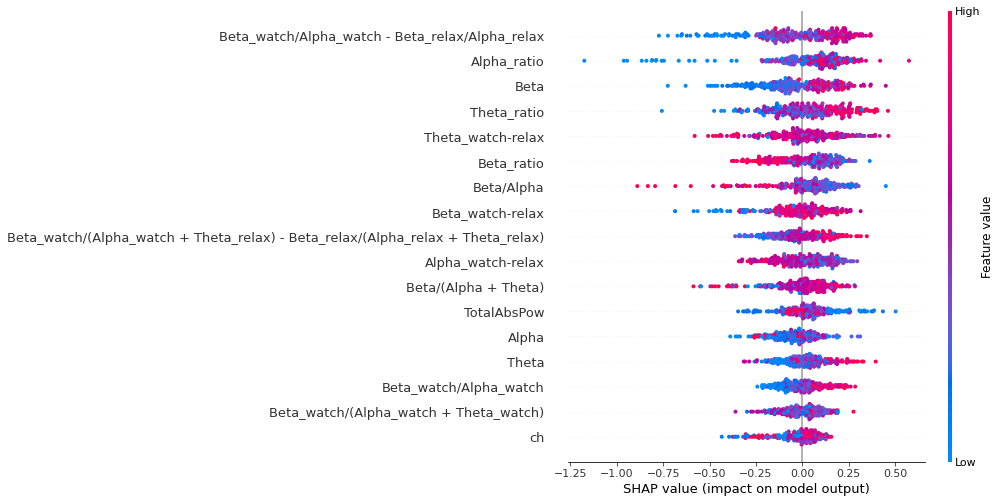

In [16]:
model = CatBoostRegressor(cat_features=['ch'])
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=len(X_train.columns), show=False)

In [17]:
model = CatBoostRegressor()
model.fit(X_train, y_train, cat_features=['ch'])

Learning rate set to 0.046125
0:	learn: 2.3710164	total: 10.3ms	remaining: 10.3s
1:	learn: 2.3602864	total: 19.6ms	remaining: 9.79s
2:	learn: 2.3509221	total: 26.5ms	remaining: 8.81s
3:	learn: 2.3438684	total: 32.9ms	remaining: 8.19s
4:	learn: 2.3342280	total: 38.6ms	remaining: 7.67s
5:	learn: 2.3268232	total: 47.7ms	remaining: 7.9s
6:	learn: 2.3196998	total: 53.2ms	remaining: 7.55s
7:	learn: 2.3121572	total: 59.2ms	remaining: 7.34s
8:	learn: 2.3041896	total: 64.7ms	remaining: 7.12s
9:	learn: 2.2976639	total: 70.3ms	remaining: 6.96s
10:	learn: 2.2894756	total: 76ms	remaining: 6.83s
11:	learn: 2.2832356	total: 81.7ms	remaining: 6.73s
12:	learn: 2.2779126	total: 87.4ms	remaining: 6.64s
13:	learn: 2.2713412	total: 93ms	remaining: 6.55s
14:	learn: 2.2644943	total: 98.7ms	remaining: 6.48s
15:	learn: 2.2594908	total: 104ms	remaining: 6.42s
16:	learn: 2.2547676	total: 110ms	remaining: 6.38s
17:	learn: 2.2490018	total: 116ms	remaining: 6.32s
18:	learn: 2.2432324	total: 123ms	remaining: 6.35s
1

In [18]:
y_pred = model.predict(X_test)
print(y_pred)

[7.85669001 5.08739235 5.3468653  7.64696375 5.42510984 7.40220057
 6.51306875 7.07011625 5.79181169 5.54607738 4.49096394 7.39598883
 6.57949206 5.72098035 4.52338712 7.0277201  7.4820191  6.90430556
 7.52579288 6.15859908 5.94797654 7.33004166 7.20457983 7.47702941
 6.81603525 6.01418654 7.08837636 7.00596301 6.23967229 7.43977197
 6.74942603 7.95891907 5.06740791 5.42017648 6.5880302  5.43828385
 5.80943375 6.1347328  4.70829534 6.44783568 5.67471959 6.54473844
 5.48203898 5.41766262 5.77442899 5.20470992 5.77615388 5.84309317
 6.66512214 5.89404831 7.03073015 7.34843464 6.22472985 4.92310288
 5.79999409 6.00726937 5.34434098 6.89858727 5.25110366 4.85316958
 6.61736536 4.38988988 6.78075375 7.40204015 6.35742379 6.05290747
 6.11693699 6.19021371 5.38078654 6.70899143 5.39411696 5.08248128
 5.60082799 5.50723142 5.80392446 5.32178115 5.53718712 6.07569269
 4.38547623 7.80158304 6.59148916 7.58587333 7.26425955 7.30841523
 6.84898711 7.45253136 7.16292935 7.70312306 6.2817209  6.8630

In [19]:
pool = Pool(X_train, y_train, cat_features=['ch'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52a27db50>]],
      dtype=object)

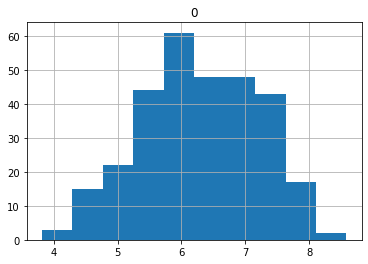

In [20]:
pd.DataFrame(y_pred).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb52a224e10>]],
      dtype=object)

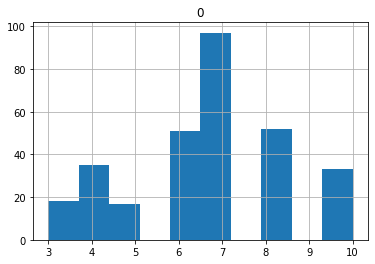

In [21]:
pd.DataFrame(y_test).hist()

In [22]:
metrics = ["MAE", "MAPE", "R2"]

In [23]:
res = model.eval_metrics(pool, metrics)

0    1.294569
dtype: float64
0    0.305101
dtype: float64
0    0.562965
dtype: float64


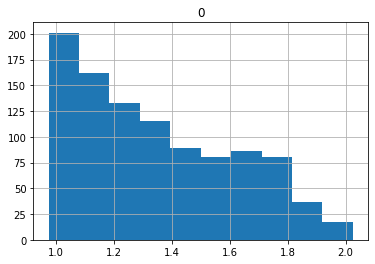

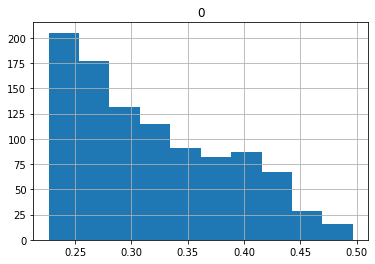

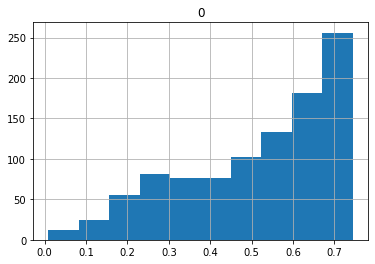

In [24]:
for metric in metrics:
  print(pd.DataFrame(res[metric]).median())
  pd.DataFrame(res[metric]).hist()